In [16]:
%matplotlib inline
from preamble import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## 모델 평가와 성능 향상

### 5.1 교차 검증

```
1. 데이터를 폴드(fold)라고 하는 비슷한 크기의 부분 집합으로 나눈다.

2. 첫번째 모델은 첫번째 폴드를 테스트 세트로 사용하고 나머지를 훈련 세트로 사용한다.

3. 2번을 n개의 폴드에 대해 n번 반복한다.

4. 각각의 정확도를 측정하여, n개의 정확도 값을 얻는다.
```

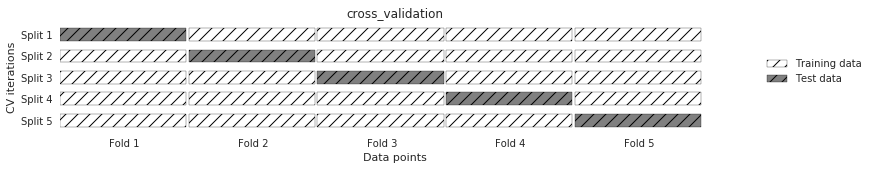

In [17]:
mglearn.plots.plot_cross_validation()

### 5.1.1 scikit-learn의 교차 검증

`cross_val_score(model, data, target, cv=3)`

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
print("교차 검증 점수: {}".format(scores))

교차 검증 점수: [0.961 0.922 0.958]


### 5.1.2 교차 검증의 장점

```
1. 모든 폴드에 대한 정확도가 좋아지는 것은 일반화가 잘 됬다는 것을 의미한다.

2. 데이터를 여러 개로 나눔으로서, 훈련 데이터가 얼마나 민감한지 알 수 있다.
```


단점 : 연산 비용이 늘어난다. n개로 나누면 n배 느리다.



### 계층별 k-겹 교차 검증

- 교차검증이 항상 좋지는 않다. 


    - 왜? 데이터가 골고루 안 섞일 수 있다.



- 계층별 k-겹 교차 검증을 사용하자. 


    - 클래스 비율이 전체 데이터 셋의 클래스 비율과 같도록 데이터를 나눈다.
    - (ex 클래스0이 90%, 클래스1이 10%인 데이터는 각 폴드에 클래스0이 90%, 클래스1이 10%)
    - 그러나 일반적인 방법은 아니다.

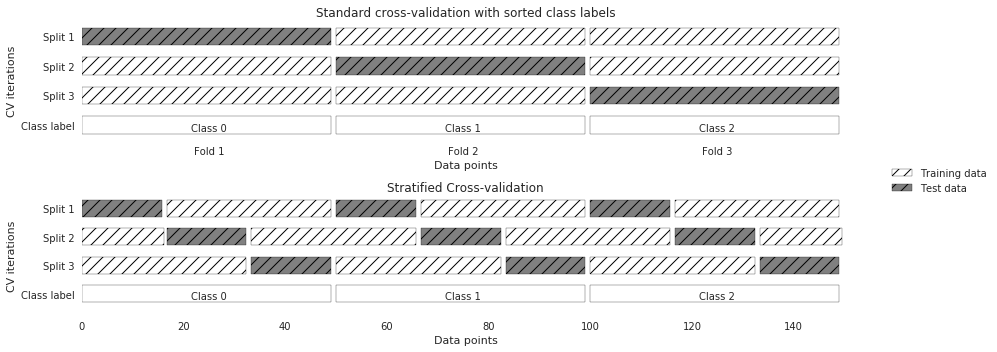

In [19]:
mglearn.plots.plot_stratified_cross_validation()

In [20]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3)
print("교차 검증 점수:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

교차 검증 점수:
[0. 0. 0.]


In [21]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0) # shuffle=True 순서를 섞는다
print("교차 검증 점수:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

교차 검증 점수:
[0.9  0.96 0.96]


### LOOCV 
(Leave-one-out cross-validation)

- 폴드 하나에 샘플 하나 (작은 데이터셋에 좋은 결과를 낸다)

### 임의 분할 교차 검증 
(shuffle-split cross validation)

- 몇개의 폴드로 나눌지, 몇개의 폴드를 train에 쓸지, 몇개의 폴드를 test에 쓸지 일일이 정해줌 

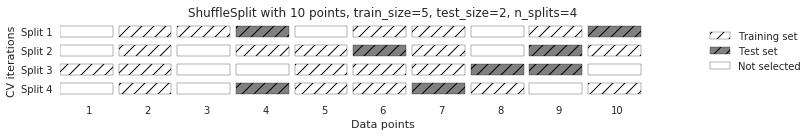

In [22]:
mglearn.plots.plot_shuffle_split()

## 5.2 그리드 서치

- 모델의 매개변수의 값을 찾는 일

In [23]:
# 간단한 그리드 서치 구현
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("훈련 세트의 크기: {}   테스트 세트의 크기: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다
        score = svm.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: {}".format(best_parameters))

훈련 세트의 크기: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 파라미터: {'C': 100, 'gamma': 0.001}


#### 교차 검증을 사용한 그리드 서치

In [24]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        # 교차 검증을 적용합니다
        scores = cross_val_score(svm, X_train, y_train, cv=5)
        # 교차 검증 정확도의 평균을 계산합니다
        score = np.mean(scores)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만듭니다
svm = SVC(**best_parameters)
svm.fit(X_train, y_train)
best_parameters

{'C': 100, 'gamma': 0.001}

#### sklearn 메소드

`GridSearchCV`

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
grid_search.fit(X_train, y_train)
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))
print("최적 매개변수: {}".format(grid_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

테스트 세트 점수: 0.97
최적 매개변수: {'C': 100, 'gamma': 0.01}
최고 교차 검증 점수: 0.97


`.best_estimator_` 최고성능 속성

In [27]:
grid_search.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

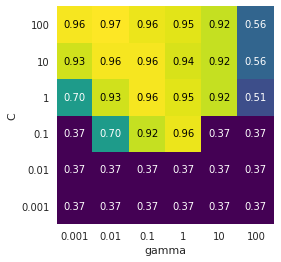

In [28]:
pd.set_option('display.max_columns', None)
# DataFrame으로 변환합니다
results = pd.DataFrame(grid_search.cv_results_) #.cv_results_ 교차 검정 결과

scores = np.array(results.mean_test_score).reshape(6, 6)

# 교차 검증 평균 점수 히트맵 그래프
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'])

## 5.3 평가 지표와 측정

### 5.3.1 최종 목표를 기억하라


- 비즈니스 지표(현실적인 실적)에 긍정적인 영향을 주는 모델과 매개변수를 선택해야 한다.


- 고객 수가 늘었지만 매출은 줄어드는 모델을 만들면 안된다.

### 5.3.2 이진 분류의 평가 지표

- 양성 클래스와 음성 클래스



#### - 에러의 종류 
```    
   False Positive (건강한데 암으로 진단)
   
   False Negative (암인데 건강하다고 진단)

```

#### - 불균형 데이터셋

- 한 클래스가 다른 것보다 훨씬 많은 데이터 셋

In [29]:
# 클래스가 9:1 (9가 아니다, 9이다) 

from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

In [60]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("예측된 레이블의 고유값: {}".format(np.unique(pred_most_frequent)))
print("테스트 점수: {:.2f}".format(dummy_majority.score(X_test, y_test)))

예측된 레이블의 고유값: [False]
테스트 점수: 0.90


In [55]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg 점수: {:.2f}".format(logreg.score(X_test, y_test)))

logreg 점수: 0.98


In [61]:
from sklearn.metrics import confusion_matrix

print("빈도 기반 더미 모델:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\n로지스틱 회귀")
print(confusion_matrix(y_test, pred_logreg))

빈도 기반 더미 모델:
[[403   0]
 [ 47   0]]

로지스틱 회귀
[[401   2]
 [  8  39]]


| | Positive라고 예측  | Negative라고 예측 | 
|-|-|-|
| 실제 Positive | TP   |  FN |             
| 실제 Negative | FP   |  TN |  

###### 정확도와의 관계
\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

###### 정밀도, 재현율, f-점수
\begin{equation}
\text{정밀도(precision)} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

\begin{equation}
\text{재현율(recall)} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{F} = 2 \cdot \frac{\text{정밀도} \cdot \text{재현율}}{\text{정밀도} + \text{재현율}}
\end{equation}

##### 정밀도 : FP를 줄이는 것이 목표일 때 성능지표이다.

- ex) 약의 치료효과 

##### 재현율 : FN을 피하는 것이 목표일 때 성능지표이다.

- ex) 암 진단

##### f-score : 정밀도와 재현율 모두 중요할때

`classification_report` 정밀도, 재현율, f-score 출력

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,
                            target_names=["9 아님", "9"]))

             precision    recall  f1-score   support

       9 아님       0.90      1.00      0.94       403
          9       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg,
                            target_names=["9 아님", "9"]))

             precision    recall  f1-score   support

       9 아님       0.98      1.00      0.99       403
          9       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450

